# Progetto di Machine Learning: Riconoscimento di Specie Animali tramite Audio

Questo notebook implementa un sistema di riconoscimento di specie animali attraverso l'analisi di registrazioni audio raccolte nell'El Silencio Natural Reserve in Colombia. Il progetto mira a identificare diverse specie animali presenti nelle registrazioni audio per il monitoraggio della biodiversità.

## 1. Importazione delle Librerie Necessarie

In [1]:
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from tqdm.notebook import tqdm
import os
import time
import warnings

warnings.filterwarnings("ignore")

## 1. Setup & Configuration

In [2]:
class Config:
    # Paths
    # Adjust these paths based on the Kaggle environment or your local setup
    # Assuming the script is run from the project root, and data is in ./dataset/
    PROJECT_ROOT = "." # Assuming you run from the project root
    DATASET_DIR = os.path.join(PROJECT_ROOT, "dataset")

    # Check if running in Kaggle, otherwise use local dataset path
    IS_KAGGLE = os.path.exists("/kaggle/input")
    COMPETITION_NAME = "birdclef-2025" # Used for Kaggle input path

    BASE_DIR = f"/kaggle/input/{COMPETITION_NAME}" if IS_KAGGLE else DATASET_DIR

    TRAIN_AUDIO_DIR = os.path.join(BASE_DIR, "train_audio")
    # TEST_SOUNDSCAPES_DIR will be populated during submission/inference on Kaggle
    # For local testing, you might need to create a dummy or point to a local test set
    TEST_SOUNDSCAPES_DIR = os.path.join(BASE_DIR, "test_soundscapes")
    TRAIN_CSV_PATH = os.path.join(BASE_DIR, "train.csv")
    TAXONOMY_CSV_PATH = os.path.join(BASE_DIR, "taxonomy.csv")
    SAMPLE_SUB_PATH = os.path.join(BASE_DIR, "sample_submission.csv")
    OUTPUT_DIR = os.path.join(PROJECT_ROOT, "output") # Suggest putting output in its own folder

    # Audio Preprocessing
    SR = 32000 # Sample rate provided
    DURATION = 5 # Duration of clips for training (seconds)
    N_MELS = 128 # Number of Mel bands
    N_FFT = 2048 # FFT window size
    HOP_LENGTH = 512 # Hop length for STFT
    FMIN = 0 # Minimum frequency for Mel spectrogram
    FMAX = SR / 2 # Maximum frequency

    # Training
    BATCH_SIZE = 32
    EPOCHS = 5 # Keep low for baseline/debugging
    LEARNING_RATE = 1e-3
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    NUM_WORKERS = 0 # Number of workers for DataLoader

    # Inference/Submission
    TEST_CLIP_DURATION = 5 # Duration of segments for prediction (seconds)
    N_CLASSES = 0 # Will be set after loading data

# Create output directory if it doesn't exist
os.makedirs(Config.OUTPUT_DIR, exist_ok=True)

print(f"Running locally: {not Config.IS_KAGGLE}")
print(f"Using device: {Config.DEVICE}")
print(f"Base data directory: {Config.BASE_DIR}")
print(f"Output directory: {Config.OUTPUT_DIR}")
print(f"Train audio directory exists: {os.path.exists(Config.TRAIN_AUDIO_DIR)}")
print(f"Train CSV path exists: {os.path.exists(Config.TRAIN_CSV_PATH)}")

Running locally: False
Using device: cuda
Base data directory: /kaggle/input/birdclef-2025
Output directory: ./output
Train audio directory exists: True
Train CSV path exists: True


## 2. Load Metadata

In [3]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer

# Carica i CSV dal dataset BirdCLEF+ 2025
train_df = pd.read_csv('/kaggle/input/birdclef-2025/train.csv')
taxonomy_df = pd.read_csv('/kaggle/input/birdclef-2025/taxonomy.csv')
sample_sub_df = pd.read_csv('/kaggle/input/birdclef-2025/sample_submission.csv')

# Get all unique species labels from training primary/secondary and submission columns
train_primary_labels = train_df['primary_label'].unique()
train_secondary_labels = set([lbl for sublist in train_df['secondary_labels'].apply(eval) for lbl in sublist if lbl])
submission_species = sample_sub_df.columns[1:].tolist()  # Exclude row_id

# Combine all possible labels
all_species = sorted(list(set(train_primary_labels) | train_secondary_labels | set(submission_species)))
N_CLASSES = len(all_species)
Config.N_CLASSES = N_CLASSES  # Aggiungi questa riga per aggiornare Config.N_CLASSES

print(f"Total unique species found: {N_CLASSES}")
print(f"First 10 species: {all_species[:10]}")

# Create label encoders
species_to_int = {species: i for i, species in enumerate(all_species)}
int_to_species = {i: species for species, i in species_to_int.items()}

# Add integer labels to train_df (for primary label)
train_df['primary_label_int'] = train_df['primary_label'].map(species_to_int)

# Prepare multilabel targets
mlb = MultiLabelBinarizer(classes=all_species)
mlb.fit(None)  # Fit with all classes

def get_multilabel(row):
    labels = eval(row['secondary_labels'])  # Safely evaluate string list
    labels.append(row['primary_label'])
    return list(set(labels))  # Ensure unique labels

train_df['all_labels'] = train_df.apply(get_multilabel, axis=1)
train_labels_one_hot = mlb.transform(train_df['all_labels'])

print(f"Shape of one-hot encoded labels: {train_labels_one_hot.shape}")
train_df.head()


Total unique species found: 206
First 10 species: ['1139490', '1192948', '1194042', '126247', '1346504', '134933', '135045', '1462711', '1462737', '1564122']
Shape of one-hot encoded labels: (28564, 206)


,primary_label,secondary_labels,type,filename,collection,rating,url,latitude,longitude,scientific_name,common_name,author,license,primary_label_int,all_labels
0,1139490,[''],[''],1139490/CSA36385.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3206,-73.7128,Ragoniella pulchella,Ragoniella pulchella,Fabio A. Sarria-S,cc-by-nc-sa 4.0,0,"[, 1139490]"
1,1139490,[''],[''],1139490/CSA36389.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3206,-73.7128,Ragoniella pulchella,Ragoniella pulchella,Fabio A. Sarria-S,cc-by-nc-sa 4.0,0,"[, 1139490]"
2,1192948,[''],[''],1192948/CSA36358.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3791,-73.7313,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0,1,"[, 1192948]"
3,1192948,[''],[''],1192948/CSA36366.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.2800,-73.8582,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0,1,"[, 1192948]"
4,1192948,[''],[''],1192948/CSA36373.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3791,-73.7313,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0,1,"[, 1192948]"


### 2.1 Suddivisione Dati in Training e Validazione

Suddividiamo il dataframe e le etichette one-hot in set di training e validazione per poter valutare i modelli.

In [4]:
from sklearn.model_selection import train_test_split

# Indici per lo split
train_indices, val_indices = train_test_split(
    range(len(train_df)),
    test_size=0.2, # 20% per la validazione
    random_state=42 # Per riproducibilità
)

# Crea i dataframe e gli array di etichette splittati
X_train_df = train_df.iloc[train_indices].reset_index(drop=True)
X_val_df = train_df.iloc[val_indices].reset_index(drop=True)

y_train_one_hot = train_labels_one_hot[train_indices]
y_val_one_hot = train_labels_one_hot[val_indices]

print(f"Dimensioni Training Set: {X_train_df.shape}, Etichette: {y_train_one_hot.shape}")
print(f"Dimensioni Validation Set: {X_val_df.shape}, Etichette: {y_val_one_hot.shape}")

# --- AGGIORNAMENTO PER LA CNN ---
# Ora usa X_train_df e y_train_one_hot per creare train_dataset e train_loader
# Potresti creare anche un val_dataset e val_loader per valutare la CNN
# Esempio (da modificare nella cella 6):
# train_dataset = BirdDataset(X_train_df, Config.TRAIN_AUDIO_DIR, y_train_one_hot)
# val_dataset = BirdDataset(X_val_df, Config.TRAIN_AUDIO_DIR, y_val_one_hot)
# train_loader = DataLoader(train_dataset, ...)
# val_loader = DataLoader(val_dataset, ...)

Dimensioni Training Set: (22851, 15), Etichette: (22851, 206)
Dimensioni Validation Set: (5713, 15), Etichette: (5713, 206)


## 3. Audio Preprocessing

In [5]:
def load_and_preprocess_audio(file_path, target_sr=Config.SR, duration=Config.DURATION):
    """Loads audio, pads/truncates, and converts to Mel spectrogram."""
    try:
        # Load audio file
        y, sr = librosa.load(file_path, sr=target_sr, mono=True)

        # Pad or truncate to target duration
        target_len = int(target_sr * duration)
        if len(y) < target_len:
            y = np.pad(y, (0, target_len - len(y)), mode='constant')
        else:
            y = y[:target_len]

        # Compute Mel spectrogram
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr,
                                                  n_fft=Config.N_FFT,
                                                  hop_length=Config.HOP_LENGTH,
                                                  n_mels=Config.N_MELS,
                                                  fmin=Config.FMIN,
                                                  fmax=Config.FMAX)

        # Convert to log scale (dB)
        log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

        # Normalize (optional, but often helpful)
        # Example: scale to [0, 1]
        min_val = np.min(log_mel_spec)
        max_val = np.max(log_mel_spec)
        if max_val > min_val:
            log_mel_spec = (log_mel_spec - min_val) / (max_val - min_val)
        else:
             log_mel_spec = np.zeros_like(log_mel_spec) # Handle silent clips


        return log_mel_spec

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        # Return a dummy array of the expected shape if error occurs
        # Shape: (n_mels, time_steps)
        # time_steps = int(target_sr * duration / hop_length) + 1
        time_steps = int(target_sr * duration / Config.HOP_LENGTH) + 1
        return np.zeros((Config.N_MELS, time_steps), dtype=np.float32)

### Test Preprocessing on one file

Processing sample file: /kaggle/input/birdclef-2025/train_audio/1139490/CSA36385.ogg
Spectrogram shape: (128, 313)


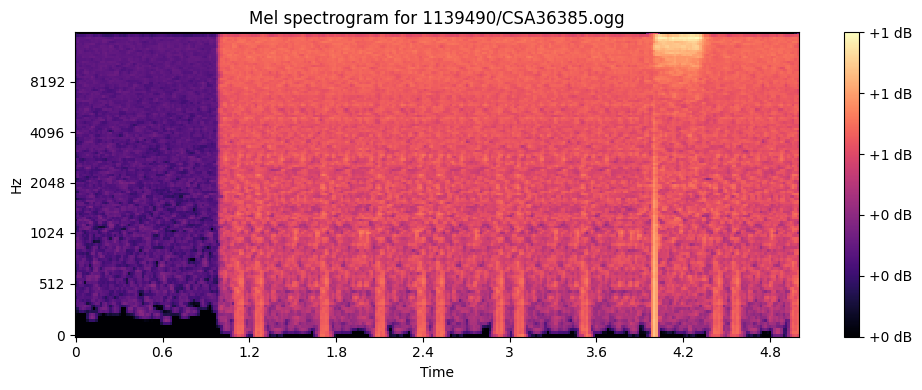

In [6]:
if not train_df.empty:
    sample_idx = 0
    sample_file = train_df.loc[sample_idx, 'filename']
    sample_path = os.path.join(Config.TRAIN_AUDIO_DIR, sample_file)
    print(f"Processing sample file: {sample_path}")

    if os.path.exists(sample_path):
        mel_spec_sample = load_and_preprocess_audio(sample_path)
        print(f"Spectrogram shape: {mel_spec_sample.shape}") # Should be (N_MELS, time_steps)

        plt.figure(figsize=(10, 4))
        librosa.display.specshow(mel_spec_sample, sr=Config.SR, hop_length=Config.HOP_LENGTH,
                                 x_axis='time', y_axis='mel', fmin=Config.FMIN, fmax=Config.FMAX)
        plt.colorbar(format='%+2.0f dB')
        plt.title(f'Mel spectrogram for {sample_file}')
        plt.tight_layout()
        plt.show()
    else:
        print(f"Sample audio file not found: {sample_path}")
else:
    print("Training dataframe is empty. Cannot process sample.")

## 4. PyTorch Dataset

In [7]:
class BirdDataset(Dataset):
    def __init__(self, df, audio_dir, labels_one_hot, transform=None):
        self.df = df
        self.audio_dir = audio_dir
        self.labels = labels_one_hot
        self.transform = transform # For potential augmentations

    def __len__(self):
        return len(self.df)

    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        # --- MODIFIED PATH CONSTRUCTION ---
        # Assume the subfolder name is the primary_label
        filename = row['filename']
        file_path = os.path.join(self.audio_dir, filename)
        # --- END MODIFICATION ---

        # Load and preprocess audio -> Mel spectrogram
        # Check if file exists before loading, helpful for debugging path issues
        if not os.path.exists(file_path):
            print(f"Warning: File not found at {file_path}. Check path construction and data structure.")
            # Return dummy data or raise error
            time_steps = int(Config.SR * Config.DURATION / Config.HOP_LENGTH) + 1
            dummy_spec = torch.zeros((1, Config.N_MELS, time_steps), dtype=torch.float32)
            dummy_label = torch.zeros(Config.N_CLASSES, dtype=torch.float32) # Adjust label size if needed
            return dummy_spec, dummy_label


        mel_spec = load_and_preprocess_audio(file_path)

        # Add channel dimension (needed for CNNs) -> (1, n_mels, time_steps)
        mel_spec = np.expand_dims(mel_spec, axis=0)

        # Convert to tensor
        mel_spec_tensor = torch.tensor(mel_spec, dtype=torch.float32)

        # Get corresponding labels
        label_tensor = torch.tensor(self.labels[idx], dtype=torch.float32)

        # Apply transformations if any (e.g., augmentations)
        if self.transform:
             mel_spec_tensor = self.transform(mel_spec_tensor) # Not implemented in baseline

        return mel_spec_tensor, label_tensor

## 5. Simple CNN Model

In [8]:
class SimpleBirdCNN(nn.Module):
    def __init__(self, num_classes=Config.N_CLASSES):
        super(SimpleBirdCNN, self).__init__()
        # Input shape: (batch_size, 1, n_mels, time_steps)
        # Example time_steps for 5s audio: int(32000 * 5 / 512) + 1 = 313
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Flatten and Fully Connected Layers
        self.flatten = nn.Flatten()
        # Calculate the flattened size dynamically or manually after one forward pass
        # For now, let's assume a dummy size, it will be calculated properly later
        # Example calculation:
        # Input: (1, 128, 313) -> After 3 pools: (128 / 2^3, 313 / 2^3) = (16, 39) approx
        # flattened_size = 128 * (Config.N_MELS // 8) * (time_steps // 8)
        # We'll use AdaptiveMaxPool2d to fix the output size before flattening
        self.adaptive_pool = nn.AdaptiveMaxPool2d((4, 4)) # Output size (4, 4) irrespective of input
        flattened_size = 128 * 4 * 4

        self.fc1 = nn.Linear(flattened_size, 256)
        self.relu4 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)
        # We'll use BCEWithLogitsLoss, so no final activation here

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = self.adaptive_pool(x) # Ensure fixed size
        x = self.flatten(x)
        x = self.dropout(self.relu4(self.fc1(x)))
        x = self.fc2(x) # Output raw logits
        return x

## 6. Training

In [9]:
# Create Datasets and DataLoaders using the split data

# --- MODIFICA: Usa X_train_df e y_train_one_hot ---
print("Creazione Training Dataset...")
train_dataset = BirdDataset(X_train_df, Config.TRAIN_AUDIO_DIR, y_train_one_hot)
train_loader = DataLoader(train_dataset, batch_size=Config.BATCH_SIZE, shuffle=True,
                          num_workers=Config.NUM_WORKERS, pin_memory=True)
print("Fatto.")

# --- AGGIUNTA: Crea Validation Dataset e DataLoader ---
print("Creazione Validation Dataset...")
val_dataset = BirdDataset(X_val_df, Config.TRAIN_AUDIO_DIR, y_val_one_hot)
val_loader = DataLoader(val_dataset, batch_size=Config.BATCH_SIZE, shuffle=False, # Non serve shuffle per la validazione
                        num_workers=Config.NUM_WORKERS, pin_memory=True)
print("Fatto.")
# --- FINE AGGIUNTA ---


# Initialize Model, Loss, Optimizer
model = SimpleBirdCNN(num_classes=Config.N_CLASSES).to(Config.DEVICE)
criterion = nn.BCEWithLogitsLoss() # Suitable for multi-label classification
optimizer = optim.Adam(model.parameters(), lr=Config.LEARNING_RATE)

print(f"\nModel loaded on {Config.DEVICE}")
# --- MODIFICA: Stampa dimensioni di entrambi i set ---
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")
print(f"Number of training batches per epoch: {len(train_loader)}")
print(f"Number of validation batches per epoch: {len(val_loader)}")
# --- FINE MODIFICA ---

Creazione Training Dataset...
Fatto.
Creazione Validation Dataset...
Fatto.

Model loaded on cuda
Number of training samples: 22851
Number of validation samples: 5713
Number of training batches per epoch: 715
Number of validation batches per epoch: 179


In [10]:
# --- Training Loop con Validation e Salvataggio su /kaggle/working/ ---

import torch
import os
import time
import matplotlib.pyplot as plt
from tqdm import tqdm

# Path del modello da caricare (se esiste)
model_load_path = "/kaggle/input/simplecnn/pytorch/default/1/baseline_bird_cnn_model_val.pth"
# Path del modello da salvare (se lo alleniamo)
model_save_path = "/kaggle/working/birdclef_trained_model.pth"

# Flag che indica se serve fare training
needs_training = False

# Controlla se il file modello esiste su input
if os.path.exists(model_load_path):
    print(f"Modello pre-addestrato trovato in {model_load_path}. Caricamento...")
    try:
        model.load_state_dict(torch.load(model_load_path, map_location=Config.DEVICE))
        model.to(Config.DEVICE)
        model.eval()
        print("Modello caricato con successo.")
        print(model)
        train_losses = []
        val_losses = []
        total_training_time = 0
    except Exception as e:
        print(f"Errore durante il caricamento del modello: {e}. Si procederà con il training.")
        train_losses = []
        val_losses = []
        needs_training = True
else:
    print(f"Nessun modello trovato in {model_load_path}. Si procederà con il training.")
    needs_training = True

# Esegui training solo se necessario
if needs_training:
    start_time_total = time.time()
    train_losses = []
    val_losses = []

    for epoch in range(Config.EPOCHS):
        epoch_start_time = time.time()

        # --- Training Phase ---
        model.train()
        running_loss = 0.0
        pbar_train = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{Config.EPOCHS} [Train]", leave=True)

        for i, (inputs, labels) in pbar_train:
            inputs = inputs.to(Config.DEVICE)
            labels = labels.to(Config.DEVICE)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            avg_loss = running_loss / (i + 1)
            pbar_train.set_postfix({'loss': f"{avg_loss:.4f}"})

        epoch_train_loss = running_loss / len(train_loader)
        train_losses.append(epoch_train_loss)

        # --- Validation Phase ---
        model.eval()
        running_val_loss = 0.0
        pbar_val = tqdm(enumerate(val_loader), total=len(val_loader), desc=f"Epoch {epoch+1}/{Config.EPOCHS} [Val]", leave=True)

        with torch.no_grad():
            for i, (val_inputs, val_labels) in pbar_val:
                val_inputs = val_inputs.to(Config.DEVICE)
                val_labels = val_labels.to(Config.DEVICE)

                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)
                running_val_loss += val_loss.item()
                avg_val_loss = running_val_loss / (i + 1)
                pbar_val.set_postfix({'val_loss': f"{avg_val_loss:.4f}"})

        epoch_val_loss = running_val_loss / len(val_loader)
        val_losses.append(epoch_val_loss)

        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time
        print(f"Epoch [{epoch+1}/{Config.EPOCHS}], Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Duration: {epoch_duration:.2f} sec")

    end_time_total = time.time()
    total_training_time = end_time_total - start_time_total
    print(f"\nTraining finished in {total_training_time/60:.2f} minutes")

    # Salva il modello addestrato su /kaggle/working/
    torch.save(model.state_dict(), model_save_path)
    print(f"Modello salvato in {model_save_path}")

    # Plot delle curve di loss
    if train_losses and val_losses:
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, Config.EPOCHS + 1), train_losses, label='Training Loss')
        plt.plot(range(1, Config.EPOCHS + 1), val_losses, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss Curves')
        plt.legend()
        plt.grid(True)
        plt.show()
else:
    print("Training saltato perché il modello è stato caricato.")


Modello pre-addestrato trovato in /kaggle/input/simplecnn/pytorch/default/1/baseline_bird_cnn_model_val.pth. Caricamento...
Modello caricato con successo.
SimpleBirdCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (adaptive_pool): AdaptiveMaxPool2d(output_size=(4, 4))
  (fc1): Linear(in_features=2048, out_features=256, bias=True)
  (relu4): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=206, bias=True

## 7. Inference on Test Data

In [ ]:
def predict_soundscape(file_path, model, device=Config.DEVICE, clip_duration=Config.TEST_CLIP_DURATION):
    """Processes a 1-minute soundscape and returns predictions per segment."""
    predictions = []
    model.eval() # Set model to evaluation mode

    try:
        y, sr = librosa.load(file_path, sr=Config.SR, mono=True)
        total_duration = librosa.get_duration(y=y, sr=sr)
        num_segments = int(np.ceil(total_duration / clip_duration))

        for i in range(num_segments):
            start_time = i * clip_duration
            end_time = start_time + clip_duration
            segment_end_time_label = (i + 1) * clip_duration # Label for submission row_id

            # Extract segment audio
            start_sample = int(start_time * sr)
            end_sample = int(end_time * sr)
            y_segment = y[start_sample:end_sample]

            # Pad if segment is shorter than clip_duration (last segment might be)
            target_len = int(sr * clip_duration)
            if len(y_segment) < target_len:
                 y_segment = np.pad(y_segment, (0, target_len - len(y_segment)), mode='constant')

            # Preprocess segment -> Mel spectrogram
            mel_spec = librosa.feature.melspectrogram(y=y_segment, sr=sr, n_fft=Config.N_FFT,
                                                      hop_length=Config.HOP_LENGTH, n_mels=Config.N_MELS,
                                                      fmin=Config.FMIN, fmax=Config.FMAX)
            log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

            # Normalize
            min_val, max_val = np.min(log_mel_spec), np.max(log_mel_spec)
            if max_val > min_val: log_mel_spec = (log_mel_spec - min_val) / (max_val - min_val)
            else: log_mel_spec = np.zeros_like(log_mel_spec)


            # Add batch and channel dimensions -> (1, 1, n_mels, time_steps)
            mel_spec_tensor = torch.tensor(log_mel_spec, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
            mel_spec_tensor = mel_spec_tensor.to(device)

            # Get model prediction (logits)
            with torch.no_grad():
                logits = model(mel_spec_tensor)
                # Convert logits to probabilities using sigmoid
                probabilities = torch.sigmoid(logits).squeeze().cpu().numpy()

            # Store prediction with row_id format
            soundscape_id = os.path.splitext(os.path.basename(file_path))[0]
            row_id = f"{soundscape_id}_{segment_end_time_label}"
            predictions.append({'row_id': row_id, 'probabilities': probabilities})

    except Exception as e:
        print(f"Error processing soundscape {file_path}: {e}")
        # Handle potential errors during soundscape processing if needed

    return predictions

## 8. Generate Submission

In [ ]:
# --- Submission Generation ---
# This part runs when submitting the notebook on Kaggle.
# The actual test_soundscapes directory will be populated by the Kaggle environment.

all_predictions = []

if os.path.exists(Config.TEST_SOUNDSCAPES_DIR) and len(os.listdir(Config.TEST_SOUNDSCAPES_DIR)) > 0:
    print(f"Found test soundscapes in: {Config.TEST_SOUNDSCAPES_DIR}")
    test_files = [os.path.join(Config.TEST_SOUNDSCAPES_DIR, f) for f in os.listdir(Config.TEST_SOUNDSCAPES_DIR) if f.endswith('.ogg')]
    print(f"Number of test soundscapes found: {len(test_files)}")

    model.to(Config.DEVICE) # Ensure model is on the correct device

    for test_file in tqdm(test_files, desc="Processing Test Soundscapes"):
        file_predictions = predict_soundscape(test_file, model, device=Config.DEVICE)
        all_predictions.extend(file_predictions)

    # Convert predictions to DataFrame matching sample submission format
    submission_df = pd.DataFrame(columns=['row_id'] + all_species)
    temp_data = []
    for pred in all_predictions:
        row_data = {'row_id': pred['row_id']}
        for i, species in enumerate(all_species):
            row_data[species] = pred['probabilities'][i]
        temp_data.append(row_data)

    if temp_data:
         submission_df = pd.DataFrame(temp_data)
         # Ensure columns are in the correct order
         submission_df = submission_df[['row_id'] + all_species]
    else:
         print("No predictions were generated.")
         # Create empty df with correct columns if needed based on sample sub
         submission_df = pd.DataFrame(columns=['row_id'] + all_species)


    print("Submission DataFrame head:")
    print(submission_df.head())

    # Save submission file
    submission_path = os.path.join(Config.OUTPUT_DIR, "submission.csv")
    submission_df.to_csv(submission_path, index=False)
    print(f"Submission file saved to: {submission_path}")

else:
    # Create a dummy submission based on sample_submission if test files aren't available
    # (e.g., when running locally without the actual test set)
    print("Test soundscape directory not found or empty. Creating dummy submission based on sample.")
    # Ensure the dummy submission has the correct species columns derived earlier
    dummy_sub = pd.DataFrame(columns=['row_id'] + all_species)
    # If sample_sub_df is available, you could try to copy its row_ids
    if os.path.exists(Config.SAMPLE_SUB_PATH):
        sample_sub_df_loaded = pd.read_csv(Config.SAMPLE_SUB_PATH)
        dummy_sub['row_id'] = sample_sub_df_loaded['row_id']
        # Fill probabilities with a default value (e.g., 1/N_CLASSES or 0)
        default_prob = 1.0 / Config.N_CLASSES if Config.N_CLASSES > 0 else 0
        for species in all_species:
            dummy_sub[species] = default_prob
    else:
        # If even sample sub isn't there, create a truly empty file
         dummy_sub = pd.DataFrame(columns=['row_id'] + all_species)


    submission_path = os.path.join(Config.OUTPUT_DIR, "submission.csv")
    dummy_sub.to_csv(submission_path, index=False)
    print(f"Dummy submission file saved to: {submission_path}")


print("Baseline script finished.")